In [1]:
import sys, os
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import cv2

from tqdm import tqdm
from scipy.special import kl_div
from scipy.stats import entropy
from tensorflow import keras
from tensorflow_probability import layers as tfpl
from tensorflow_probability import distributions as tfd
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import InputLayer, MaxPooling2D, Conv2D, Flatten, Dropout, Dense, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow_probability.python.distributions import kl_divergence
from tensorflow.keras.applications import InceptionV3

2024-08-04 10:48:47.499651: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-04 10:48:48.181278: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
  # Restrict TensorFlow to only allocate 10GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 20000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2024-08-04 10:48:49.535934: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-04 10:48:49.561994: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-04 10:48:49.562265: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
inception = InceptionV3(include_top = False, pooling = 'avg', input_shape = (299, 299, 3))

In [4]:
hf_test = h5py.File('/data/HSC/HSC_v6/temp/64x64/5x64x64_testing_small_uniform.hdf5', 'r')
x_test = np.asarray(hf_test['image'][0 : ])

for i in range(len(x_test)): 
    x_test[i] = x_test[i] / np.amax(x_test[i])

In [5]:
hf_val = h5py.File('/data/HSC/HSC_v6/temp/64x64/5x64x64_validation_small_uniform.hdf5', 'r')
x_val = np.asarray(hf_val['image'][0 : ])

for i in range(len(x_val)): 
    x_val[i] = x_val[i] / np.amax(x_val[i])

In [6]:
hf_cvae = h5py.File('/data/HSC_generated/HSC_generated_v1/cvae/64x64/5x64x64_testing.hdf5', 'r')
x_cvae = np.asarray(hf_cvae['image'][0 : ])

for i in range(len(x_cvae)): 
    x_cvae[i] = x_cvae[i] / np.amax(x_cvae[i])

In [7]:
hf_diffusion = h5py.File('/data/HSC_generated/HSC_generated_v1/ddpm/64x64/5x64x64_testing.hdf5', 'r')
x_diffusion = np.asarray(hf_diffusion['image'][0 : ])

# Normalize each image in the dataset
for i in range(len(x_diffusion)):
    img_min = np.min(x_diffusion[i])
    img_max = np.max(x_diffusion[i])

    if img_max - img_min != 0:
        x_diffusion[i] = ((x_diffusion[i] - img_min) / (img_max - img_min)) * 2 - 1
    else:
        x_diffusion[i] = x_diffusion[i] - img_min

print(np.max(x_diffusion), np.min(x_diffusion))

1.0 -1.0


hf_gan = h5py.File('/data/HSC_generated/HSC_generated_v1/step1/64x64/5x64x64_gan_generated.hdf5', 'r')
x_gan = np.asarray(hf_gan['image'][0 : ])

for i in range(len(x_gan)): 
    x_gan[i] = x_gan[i] / np.amax(x_gan[i])

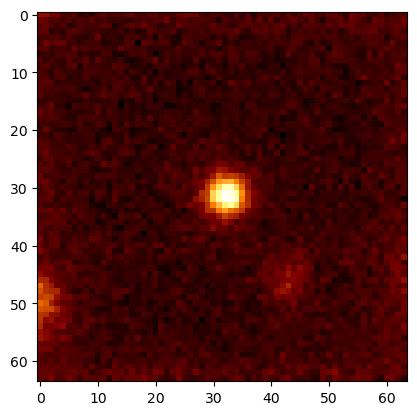

In [8]:
plt.imshow(x_diffusion[29][0], cmap = 'afmhot')

In [9]:
five_band_images_cvae = np.zeros((5, 2000, 299, 299, 3))

for band in range(5):
    
    # Iterate through bands, and length of image array
    
    for i in tqdm(range(2000)):
        
        resized_image = cv2.resize(x_cvae[i][band], (299, 299))
        stacked_image = np.nan_to_num(np.stack([resized_image] * 3, axis = -1))
        five_band_images_cvae[band][i] = stacked_image

100%|██████████| 2000/2000 [00:03<00:00, 663.63it/s]


five_band_images_gan = np.zeros((5, 2000, 299, 299, 3))

for band in range(5):
    
    # Iterate through bands, and length of image array
    
    for i in tqdm(range(2000)):
        
        resized_image = cv2.resize(x_gan[i][band], (299, 299))
        stacked_image = np.nan_to_num(np.stack([resized_image] * 3, axis = -1))
        five_band_images_gan[band][i] = stacked_image

In [10]:
five_band_images_diffusion = np.zeros((5, 2000, 299, 299, 3))

for band in range(5):
    
    # Iterate through bands, and length of image array
    
    for i in tqdm(range(2000)):
        
        resized_image = cv2.resize(x_diffusion[i][band], (299, 299))
        stacked_image = np.nan_to_num(np.stack([resized_image] * 3, axis = -1))
        five_band_images_diffusion[band][i] = stacked_image

100%|██████████| 2000/2000 [00:03<00:00, 557.33it/s]


In [11]:
five_band_images_test = np.zeros((5, 2000, 299, 299, 3))

for band in range(5):
    
    # Iterate through bands, and length of image array
    
    for i in tqdm(range(1806)):
        
        resized_image = cv2.resize(x_test[i][band], (299, 299))
        stacked_image = np.nan_to_num(np.stack([resized_image] * 3, axis = -1))
        five_band_images_test[band][i] = stacked_image

100%|██████████| 1806/1806 [00:07<00:00, 245.94it/s]


In [12]:
five_band_images_val = np.zeros((5, 2000, 299, 299, 3))

for band in range(5):
    
    # Iterate through bands, and length of image array
    
    for i in tqdm(range(1782)):
        
        resized_image = cv2.resize(x_val[i][band], (299, 299))
        stacked_image = np.nan_to_num(np.stack([resized_image] * 3, axis = -1))
        five_band_images_val[band][i] = stacked_image

100%|██████████| 1782/1782 [00:04<00:00, 401.51it/s]


In [14]:
def calculate_inception_score(images, inception_model):

    preds = inception_model.predict(images)
    preds = preds - np.max(preds, axis = 1, keepdims = True)

    exp_preds = np.exp(preds)
    sum_exp_preds = np.sum(exp_preds, axis=1, keepdims=True)
    preds = exp_preds / sum_exp_preds
    
    epsilon = 1e-10
    preds = np.clip(preds, epsilon, 1. - epsilon)
    
    mean_preds = np.mean(preds, axis=0)
    kl_divergences = preds * (np.log(preds) - np.log(np.expand_dims(mean_preds, 0)))
    
    sum_kl_divergences = np.sum(kl_divergences, axis=1)
    avg_kl_divergence = np.mean(sum_kl_divergences)

    inception_score = np.exp(avg_kl_divergence)
    return inception_score

In [13]:
def calculate_inception_score_five_band(images, inception_model):
    
    total_score = 0
    
    for i in range(0, 5):
    
        preds = inception_model.predict(images[i])
        preds = preds - np.max(preds, axis = 1, keepdims = True)

        exp_preds = np.exp(preds)
        sum_exp_preds = np.sum(exp_preds, axis = 1, keepdims = True)
        preds = exp_preds / sum_exp_preds
    
        epsilon = 1e-10
        preds = np.clip(preds, epsilon, 1. - epsilon)
    
        mean_preds = np.mean(preds, axis = 0)
        kl_divergences = preds * (np.log(preds) - np.log(np.expand_dims(mean_preds, 0)))

        sum_kl_divergences = np.sum(kl_divergences, axis = 1)
        avg_kl_divergence = np.mean(sum_kl_divergences)
    
        inception_score = np.exp(avg_kl_divergence)
        total_score += inception_score / 5
    
    return total_score

In [15]:
calculate_inception_score_five_band(five_band_images_test, inception)

2024-08-04 10:51:48.659083: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2145624000 exceeds 10% of free system memory.
2024-08-04 10:51:51.861143: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2145624000 exceeds 10% of free system memory.
2024-08-04 10:51:54.809632: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-08-04 10:51:55.191637: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-08-04 10:51:55.694285: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


63/63 [==============================] - 6s 37ms/step


2024-08-04 10:52:02.944942: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2145624000 exceeds 10% of free system memory.
2024-08-04 10:52:05.379418: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2145624000 exceeds 10% of free system memory.


63/63 [==============================] - 2s 25ms/step


2024-08-04 10:52:10.918960: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2145624000 exceeds 10% of free system memory.


63/63 [==============================] - 2s 26ms/step


1.0507938385009765

In [16]:
calculate_inception_score_five_band(five_band_images_val, inception)

63/63 [==============================] - 2s 26ms/step


1.0513185024261475

In [ ]:
calculate_inception_score_five_band(five_band_images_cvae, inception)

63/63 [==============================] - 2s 25ms/step


In [ ]:
calculate_inception_score_five_band(five_band_images_diffusion, inception)

In [ ]:
calculate_inception_score_five_band(five_band_images_gan, inception)

In [ ]:
from scipy.linalg import sqrtm

def calculate_fid(real_features, generated_features):
    
    mu1, sigma1 = real_features.mean(axis = 0), np.cov(real_features, rowvar = False)
    mu2, sigma2 = generated_features.mean(axis = 0), np.cov(generated_features, rowvar = False)
    
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    
    covmean = sqrtm(sigma1.dot(sigma2))
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    
    return fid

In [ ]:
def calculate_fid(real_features, generated_features):
    
    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = generated_features.mean(axis=0), np.cov(generated_features, rowvar=False)
    
    ssdiff = np.sum((mu1 - mu2)**2.0)
    
    covmean = sqrtm(sigma1.dot(sigma2))
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    
    return fid

In [ ]:
test_features = inception.predict(five_band_images_test[0])
cvae_features = inception.predict(five_band_images_cvae[0])
fid_score_cvae = calculate_fid(test_features, cvae_features)
print(fid_score_cvae)

In [ ]:
test_features = inception.predict(five_band_images_test[0])
val_features = inception.predict(five_band_images_val[0])
fid_score_val = calculate_fid(test_features, val_features)
print(fid_score_val)

In [ ]:
test_features = inception.predict(five_band_images_test[0])
diffusion_features = inception.predict(five_band_images_diffusion[0])
fid_score_diffusion = calculate_fid(test_features, diffusion_features)
print(fid_score_diffusion)

In [ ]:
test_features = inception.predict(five_band_images_test[0])
gan_features = inception.predict(five_band_images_gan[0])
fid_score_gan = calculate_fid(test_features, gan_features)
print(fid_score_gan)

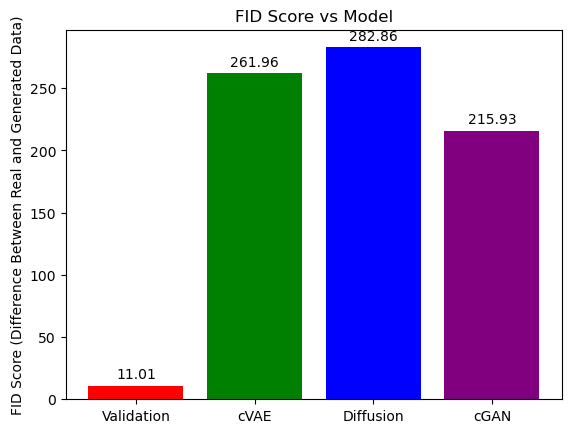

In [18]:
labels = ['Validation', 'cVAE', 'Diffusion', 'cGAN']
values = [11.01, 261.96, 282.86, 215.93]

# Create figure and axes
fig, ax = plt.subplots()

# Generate the bars
bars = plt.bar(labels, values, color=['red', 'green', 'blue', 'purple'])

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('FID Score (Difference Between Real and Generated Data)')
ax.set_title('FID Score vs Model')
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)

# Label the bars with their values
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.show()

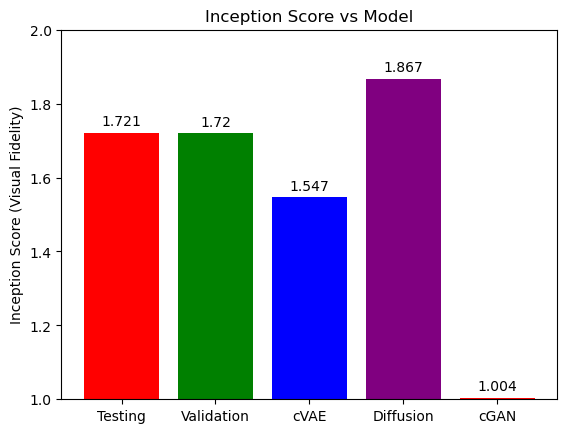

In [21]:
labels = ['Testing', 'Validation', 'cVAE', 'Diffusion', 'cGAN']
values = [1.721, 1.72, 1.547, 1.867, 1.004]

# Create figure and axes
fig, ax = plt.subplots()

# Generate the bars
bars = plt.bar(labels, values, color=['red', 'green', 'blue', 'purple'])

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Inception Score (Visual Fidelity)')
ax.set_title('Inception Score vs Model')
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)

# Label the bars with their values
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.ylim(1, 2)    

plt.show()

In [ ]:
# END